### Chapter 7.3
# M/D/1 vs. nD/D/1 GI/GI/1 Waiting Time Distributions
---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

On the example of the Internet of Things (IoT), the superposition of
periodic traffic from $n$ sensor nodes is investigated yielding an nD/D/1 queueing system. Here, the Palm-Khintchine theorem may be applied to approximate the system with an M/D/1 queue. But the question arises, how large must $n$ be such that the aggregated IoT traffic may be properly (i.e. with negligible bias) approximated by a Poisson process?

In other wors: when $n$ is large enough a Poisson process (M/D/1) can be used instead of the aggregated periodic traffic (nD/D/1). This approximation is used for dimensioning an IoT load balancer which is the first point of the IoT
cloud architecture where the individual traffic flows become aggregated. Such a load
balancer is required to distribute the workload across the back-end servers. The difference of the waiting time distributions for the nD/D/1 and the approximating M/D/1 system are quantified.

## System Description
 Consider periodic traffic from $n$ asynchronous IoT sensors sending every time $\Delta t$. The processing times $B$ of the load balancer are constant, e.g. for computing hashes of the incoming packets. The deterministic service times have the following Laplace transform.
 
$ B \sim D(b)$  with $E[B]=b$  and  $ \Phi_B(s) = e^{-s b}$

## nD/D/1 Queue

The nD/D/1 waiting time has the following cumulative distribution function:

$ \displaystyle
 W(t) = 1-\!\!\!\sum_{k=\lceil t/b \rceil}^{n-1} \binom{n-1}{k}\left( \frac{kb-t}{\Delta t}\right)^k \left(1-\frac{kb-t}{\Delta t} \right)^{n-1-k}  \frac{\Delta t-(n-1)\cdot b+t}{\Delta t -k \cdot b +t}
$

The mean waiting time is based on the Erlang-B formula $B(n,a)$. For its computation, the iterative method is used.
$  \displaystyle
	E[W]= \frac{(n-1)\rho b}{2 n\cdot B(n-2,n/\rho)}  \\
	B(0,a)=1 \;, \quad {B(n,a)} = \left(1 + \frac{n}{a\cdot B(n-1,a)} \right)^{-1}
$

In [7]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom, factorial
from scipy.stats import poisson


#%% CCDF of nD/D/1 queue
def ndd1_ccdf(t, n, deltaT, EB):
    
    def single_ndd1_ccdf(ti, n, deltaT, EB):
        m = np.arange(min(n-1, int(ti/EB)+1), n )
        x = (m*EB-ti)/deltaT
        z = binom(n-1, m)*x**m*(1-x)**(n-1-m)*(deltaT-(n-1)*EB+ti)/(deltaT-m*EB+ti)
        return z.sum()
    
    if np.isscalar(t):
        return single_ndd1_ccdf(t, n, deltaT, EB)
    else:
        y = [single_ndd1_ccdf(ti, n, deltaT, EB) for ti in t]        
        return np.array(y)
    


## M/D/1 queue

The CDF of the waiting time in an M/D/1 system is

$ \displaystyle
W(t) = (1-\lambda b) \sum_{k=0}^{\lfloor t/b\rfloor} \frac{(\lambda (k\cdot b - t))^k}{k!}e^{-(\lambda (k\cdot b - t))} \cdot 
$

Alternatively, the approach by Iversen is used for fast numerical computation of the CDF
of the waiting times for M/D/1.


The mean of the waiting time follows from Takacs recursion with $E[B^2] = b^2$ or the Laplace transform $E[W] = - \frac{d}{ds}\Phi_W(s) |_{s=0}$.

$ \displaystyle
E[W]  = \frac{\lambda E[B^2]}{2(1-\rho)} = \frac{\rho b}{2(1-\rho)} 
$

In [19]:
#%% CDF of M/D/1 queue
def md1_ccdf(t, lam, EB):
    
    def single_md1_cdf(ti, lam, EB):
        nus = np.arange(int(ti/EB)+1)        
        z = [lam**nu*(nu*EB-ti)**nu/factorial(nu)*np.exp(-lam*(nu*EB-ti))        for nu in nus]
        return np.sum(z)*(1-lam*EB)
    
    if np.isscalar(t):
        return single_md1_cdf(t, lam, EB)
    else:
        y = [single_md1_cdf(ti, lam, EB) for ti in t]        
        return np.array(y)    

    
#%% Iversen's approach
def iversen(t, lam, EB):
    rho = lam*EB
    imax = max(50,int(t.max()/EB)+1)
    fry = np.zeros(imax)
    fry[0] = 1-rho
    fry[1] = (1-rho)*(np.exp(rho)-1)
    pnuv = lambda nu, A:  (A)**nu/factorial(nu)*np.exp(-A)        
    pih = lambda i, EB: pnuv(i,lam*EB)
    
    for i in range(2,imax):    
        s = [fry[nu]*pih(i-nu,EB) for nu in np.arange(2,i)]
        fry[i]=1.0/pih(0,EB)*(fry[i-1]-(fry[0]+fry[1])*pih(i-1,EB) - np.sum(s) )
    
    def pWt(t):
        T = int(t)
        tau = t-T
        p=0
        for i in range(T+1):        
            x = [pnuv(nu,-rho*tau) for nu in range(T-i+1)]
            p += fry[i]*np.sum(x)
        return p
    
    ps = map(pWt, t)
    return np.array(list(ps))

## Comparison of M/D/1 and nD/D/1 Waiting Times
Complementary cumulative distribution function of the waiting times for $n=500$, $b=1$, $\rho=\lambda b=0.9, \Delta t=n/\rho$ for an nD/D/1 and the corresponding M/D/1 system.

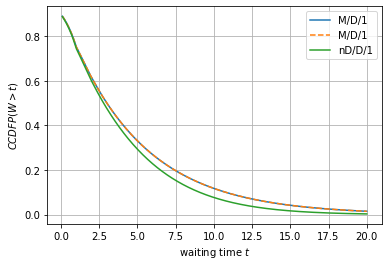

In [23]:
n = 500
rho = 0.9
EB = 1

deltaT = n/rho*EB
lam = n/deltaT 
    
t = np.linspace(0.1,20, 501)
y = 1-iversen(t, lam, EB)
plt.plot(t, y, label='M/D/1')

plt.plot(t, 1-md1_cdf(t, lam, EB), '--', label='M/D/1')
plt.plot(t, ndd1_ccdf(t, n, deltaT, EB), label='nD/D/1')

plt.grid(which='major')
plt.legend()
plt.xlabel('waiting time $t$')
plt.ylabel('$CCDF P(W>t)$');

## Comparison of Means
The mean waiting times are depicted for the nD/D/1 system depending on the number of nodes $n$ for different offered loads $\rho$ and $b=1$. The dashed lines indicate the corresponding M/D/1 system. The legend indicates which is the minimal number $n^*$ of nodes resulting in a relative error between the mean waiting times smaller than $\epsilon=2\%$. 

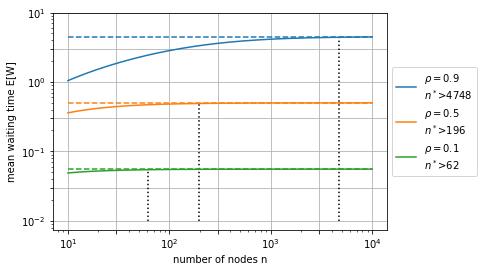

In [30]:
def erlangB(n,a):
    x = 1.0
    for i in range(1,n+1):
        x= 1.0/(1+(i/(a*x)))
    return x

def meanW_ndd1(ni, rho=0.95):
    if np.isscalar(ni): ni=np.array([ni])
    x = np.zeros_like(ni, dtype=float)
    for i, n in enumerate(ni):
        EB=1
        #deltat=n/rho
        x[i] = (n-1)*EB*rho/(2*n*erlangB(n-2,n/rho))
    return x

def meanW_md1(rho=0.95):    
    return rho*1/(2*(1-rho))


n = np.unique(np.hstack((np.logspace(1, 4, 501, dtype=int),
                         np.arange(4700,4800),
                         np.arange(50,70),
                         np.arange(180,210))))

rhos = [0.10, 0.5, 0.90][::-1]
eps = 0.02
for i, rho in enumerate(rhos):
    ym = meanW_md1(rho)
    yd = meanW_ndd1(n, rho)
    k = np.argwhere(1-yd/ym<eps)
    if len(k)>0:
        plt.plot([n[k[0][0]]]*2, [1e-2, ym], 'k:')
        label = f'$\\rho=${rho}\n$n^*$>{n[k[0][0]]}'
    else:
        label = f'{rho}'
    plt.plot(n, [ym]*len(n), '--', color=plt.cm.tab20(2*i))
    
    plt.plot(n, yd, label=label, color=plt.cm.tab20(2*i))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('number of nodes n')
plt.ylabel('mean waiting time E[W]')
plt.yscale('log')
plt.xscale('log')
f = 3
plt.xticks([10, f*10, 100, f*100, 1000, f*1000, 10000])

plt.yticks([1e-2, f*1e-2, 1e-1, f*1e-1, 1e0, f*1e0, 1e1])
plt.grid(which='major')